### Libraries

In [ ]:
pip install datasets

In [ ]:
# Libraries
import pandas as pd
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from datasets import load_dataset, concatenate_datasets
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Layer
import time
import numpy as np
import random
import matplotlib.pyplot as plt
import os

In [ ]:
# To ensure reproducible results (as much as possible)
tf.keras.utils.set_random_seed(1234)

### Task vectors



Proposed in ["Editing Models with Task Arithmetic"](https://arxiv.org/abs/2212.04089), task arithmetic is a new paradigm for adapting neural networks to new tasks.

This paradigm is based on task vectors, defined as a direction in the weight
space of a pre-trained model towards a space region in which results on a
task are improved.
Such vectors, once obtained, can be added or subtracted, leading to different results.


### Data loading

The following dataset is taken from Hugging Face.

It consists of $33,236$ correct and uncorrect sentences.

For each sentence we have:
- the initial sentence;
- the corrected sentence;
- the type of errors contained in  the sentence.

This dataset is used for Grammar Error Correction, but for simplicty we will modify this to just perform Detection.

In [ ]:
# Load the dataset
original_dataset = load_dataset("matejklemen/clc_fce")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/28350 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2191 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2695 [00:00<?, ? examples/s]

### **Goal**


 I want to use **tasks vectors** to generalize two tasks.

 From the pretrained model **BERT**, taken from Hugging Face,  I will fine-tune two different models:
 - $\tau_1$ will specialize in detecting **spelling errors** in setences;
 - $\tau_2$ will specialize in detecting **logical errors** in setences.

For each of those models we will compute a **task vector** ($v_1$ and $v_2$), and I will use them to obtain another model, $\tau_{mix}$ that, hopefully, will be able to **generalize** the BERT-encoding layer for the two mixed tasks.

### **Data preprocessing**



For each model, $\tau_1,\tau_2,\tau_{mix}$, we will need three datasets: $D_1,D_2,D_{mix}$ .

The datasets need to respect the following constraints:
- $D_1$ and $D_2$ can't contain any element of $D_{mix}$ test set;
- $D_1$ and $D_2$ should be distinct with respect to their tasks.

Let's start by building $D_{mix}$.
We will use the default splitting propoused by the HuggingFace dataset:

In [ ]:
# Get D_mix
D_mix_train = original_dataset["train"]
D_mix_val = original_dataset["validation"]
D_mix_test = original_dataset["test"]

We will use the $D_{mix}$ train and validation sets to build $D_1$ and $D_2$.


In [ ]:
# Define dataset as the train and validation of D_mix
dataset =  concatenate_datasets([D_mix_train, D_mix_val])
dataset = dataset.shuffle()


Before splitting in $D_1$ and $D_2$ let's trasform all our datasets in the desired format of **sentence-label**.


In [ ]:
# Get D_mix train,val and test into the sentence-label format
D_mix_train_x = np.array([' '.join(sentence) for sentence  in D_mix_train["src_tokens"]])
D_mix_val_x = np.array([' '.join(sentence) for sentence  in D_mix_val["src_tokens"]])
D_mix_test_x = np.array([' '.join(sentence) for sentence  in D_mix_test["src_tokens"]])

D_mix_train_y = np.array([correction == [] for correction  in D_mix_train["corrections"]])*1
D_mix_val_y = np.array([correction == []  for correction  in D_mix_val["corrections"]])*1
D_mix_test_y = np.array([correction == []  for correction  in D_mix_test["corrections"]])*1


# Get dataset train,val and test into the sentence-label format
dataset_x = np.array([' '.join(sentence) for sentence in dataset["src_tokens"]])
dataset_y = np.array([correction == []  for correction in dataset["corrections"]])*1

We want to split this dataset into $D_1$ and $D_2$.

In order to do so we need to check the type of errors in our dataset.

We will use the following function:

In [ ]:
# For each list of corrections returns "NO_ERR" if it is empty or the actual list of corrections otherwise
def get_correction(corrections_list):
  if corrections_list == []:
    return(np.array(["NO_ERR"]))
  else:
    corrections = np.array([])
    for correction_dict in corrections_list:
      correction = correction_dict["corr_type"].split(":")[1]
      corrections = np.append(corrections,correction)
    return np.array(corrections)

Let's use it to obtain the errors of each sentence:

In [ ]:
# Get, for each sentence, the list of errors
errors = np.array([get_correction(corrections_list) for corrections_list in dataset["corrections"]])

# Remove the NO_ERR case (keep only real errors), we will use it later
only_errors = errors[["NO_ERR" not in i for i in errors]]

<ipython-input-10-c3c743c7617a>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  errors = np.array([get_correction(corrections_list) for corrections_list in dataset["corrections"]])


Let's check what type of errors are annotated in our dataset:

In [ ]:
# Let's first check what type of errors our data checks
unique_errors = np.unique([item for sublist in errors for item in sublist])
print(unique_errors)

['ADJ' 'ADV' 'CONJ' 'CONTR' 'DET' 'MORPH' 'NOUN' 'NO_ERR' 'ORTH' 'OTHER'
 'PART' 'PREP' 'PRON' 'PUNCT' 'SPELL' 'VERB' 'WO']


In [ ]:
# Print for each type of error a sentence that contains it
for error in unique_errors:
  for i in range(len(errors)):
    if error in errors[i]:
      sentence = ' '.join(dataset["src_tokens"][i])
      print(f"{error}: {sentence}")
      break

ADJ: Another complain is about the time that the musical show started , the advertisement said it started at 19:30 , but it did not , we had to wait 45 minutes .
ADV: Howeve it was great job I haven't hade such experience .
CONJ: Then I was sitted with my friend just waiting for the start that lasted forever and was supposed to start at 19:30 .
CONTR: If I 'm not lucky enough to find one , then I 'll have to take a train trip to a larger shopping places such as London .
DET: I would like to assure you that I would do my best to be the one of the winners in your competition .
MORPH: The concert was organized by the community so everyone who wanted to help was welcomed .
NOUN: Another complain is about the time that the musical show started , the advertisement said it started at 19:30 , but it did not , we had to wait 45 minutes .
NO_ERR: Tennis I only started four years ago , but have found that I am quite talented at it , having won several competitions during the last two years or so 

Let's see how this errors are distributed (note that each sentence may have more then one type of error):

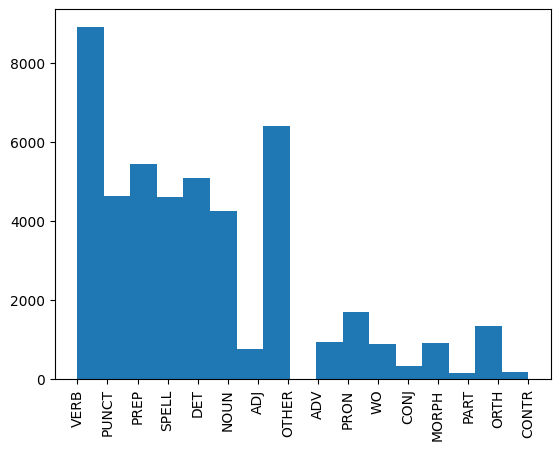

In [ ]:
# Plot errors distributions
plt.hist(np.array([item for sublist in only_errors for item in sublist]), bins = len(unique_errors))
plt.xticks(rotation='vertical')
plt.show()

We can associate the **spelling** errors with the classes: **SPELL** and **ORTH**.

Let's check if they represent enough cases to make split the dataset with balance:

In [ ]:
# Number of errors of "PUNCT", "SPELL" and "ORTH" between all errors
np.mean(["PUNCT" in errors_list or "SPELL" in errors_list or "ORTH" in errors_list for errors_list in only_errors])

0.4020958868221116

The **spelling errors** represent **40%** of the errors, which is good.

We can proceed with the splitting:
- $D_1$ will contain all the **PUNCT** and **SPELL** errors, and half of the correct sentences;
- $D_2$ will contain all the other errors, and the remaining half of correct sentences.

To split the correct cases we will use the following function:

In [ ]:
# Split index vector in two complementary vectors
def split_index_vector(index_vector):
    total_sum = np.sum(index_vector)
    target_sum = total_sum / 2

    # Create a cumulative sum array
    cum_sum = np.cumsum(index_vector)

    # Find the index where the cumulative sum is closest to half of the total sum
    split_index = np.abs(cum_sum - target_sum).argmin()

    # Create the two resulting vectors with the same length as the original vector
    vector1 = np.concatenate([index_vector[:split_index + 1], np.zeros(len(index_vector) - split_index - 1)])
    vector2 = np.concatenate([np.zeros(split_index + 1), index_vector[split_index + 1:]])

    return vector1, vector2


Let's proceed with the splitting:

In [ ]:
# Divide the correct sentences equally between first and second task
first_task_correct_setences, second_task_correc_setences = split_index_vector(dataset_y)

# Divide spelling errors from other
spelling_errors_indexes = np.array(["PUNCT" in errors_list or "SPELL" in errors_list or "ORTH" in errors_list for errors_list in errors])
other_errors_indexes = np.array(["PUNCT" not in errors_list and "SPELL" not in errors_list and "ORTH" not in errors_list and "NO_ERR" not in errors_list for errors_list in errors])

# Get tasks final indexes
spelling_task_indexes = np.array((first_task_correct_setences + spelling_errors_indexes).astype(int))
other_task_indexes = np.array((second_task_correc_setences + other_errors_indexes).astype(int))

Now we can obtain $D_1$ and $D_2$:

In [ ]:
# Get final datasets:
D1_x = dataset_x[spelling_task_indexes == 1]
D1_y = dataset_y[spelling_task_indexes == 1]

D2_x = dataset_x[other_task_indexes == 1]
D2_y = dataset_y[other_task_indexes == 1]

#### Tokenization

In order to use **BERT** we will need first to tokenize our sentences.

Let's start by loading the BERT tokenizer from hugging-face, and defining a function to use it:

In [ ]:
# Load BERT model and tokenizer
model_name = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)

# Tokenize function
def tokenize(sentence,  padding = "max_length", max_length = 250):
  return tokenizer(sentence, padding = padding, max_length = max_length, return_tensors = "np")["input_ids"]

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Let's apply the tokenize function on all our datasets inputs:

In [ ]:
# Tokenize D1 and D2 input sentences
D1_x = [tokenize(sentence) for sentence in D1_x]
D2_x = [tokenize(sentence) for sentence in D2_x]

# Tokenize D_mix train/val/test input sentences
D_mix_train_x = [tokenize(sentence) for sentence in D_mix_train_x]
D_mix_val_x = [tokenize(sentence) for sentence in D_mix_val_x]
D_mix_test_x = [tokenize(sentence) for sentence in D_mix_test_x]

What remains is just splitting our $D_1$ and $D_2$ into train, validation and test:

In [ ]:
# Split D1 and D2 in train, val and test
D1_train_x, X_temp, D1_train_y, y_temp = train_test_split(D1_x, D1_y, test_size=0.3, random_state=42)
D1_val_x, D1_test_x, D1_val_y, D1_test_y = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

D2_train_x, X_temp, D2_train_y, y_temp = train_test_split(D2_x, D2_y, test_size=0.3, random_state=42)
D2_val_x, D2_test_x, D2_val_y, D2_test_y = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

Finally let's obtain the datasets ready for training:

In [ ]:
# Get D1 dataset
D1_train = tf.data.Dataset.from_tensor_slices((np.concatenate(D1_train_x, axis=0),D1_train_y[:, np.newaxis])).batch(32)
D1_val = tf.data.Dataset.from_tensor_slices((np.concatenate(D1_val_x, axis=0),D1_val_y[:, np.newaxis])).batch(32)
D1_test = tf.data.Dataset.from_tensor_slices((np.concatenate(D1_test_x, axis=0),D1_test_y[:, np.newaxis])).batch(32)

# Get D2 dataset
D2_train = tf.data.Dataset.from_tensor_slices((np.concatenate(D2_train_x, axis=0),D2_train_y[:, np.newaxis])).batch(32)
D2_val = tf.data.Dataset.from_tensor_slices((np.concatenate(D2_val_x, axis=0),D2_val_y[:, np.newaxis])).batch(32)
D2_test = tf.data.Dataset.from_tensor_slices((np.concatenate(D2_test_x, axis=0),D2_test_y[:, np.newaxis])).batch(32)

# Get D_mix dataset
D_mix_train = tf.data.Dataset.from_tensor_slices((np.concatenate(D_mix_train_x, axis=0),D_mix_train_y[:, np.newaxis])).batch(32)
D_mix_val = tf.data.Dataset.from_tensor_slices((np.concatenate(D_mix_val_x, axis=0),D_mix_val_y[:, np.newaxis])).batch(32)
D_mix_test = tf.data.Dataset.from_tensor_slices((np.concatenate(D_mix_test_x, axis=0),D_mix_test_y[:, np.newaxis])).batch(32)

### **Training set up**

Let's set here the parameters we will use for training.
We will train two kind of models:
- models trained to modify **all** BERT's weights;
- models trained to modify only the classifier part.

The first kind of models will need a really low learning rate in order to not fall into the **catastrophic forgetting** danger.

The others can afford a higher learning rate.

Here we set those learning rates:

In [ ]:
# Setting learning rates
low_lr = 10**-5
high_lr = 10**-2

We also need to set the number of epochs of each training.

Since we will train in total $4$ models we can't really explore in depths the training phase.

We will train for $5$ epochs each model.

In [ ]:
# Set number of epochs
number_of_epochs = 5

We will save the best model whit respect to val loss

In [ ]:
# Save the best weights based on validation loss (its already set up to save your best weights in case you want to retrain CNN)
def get_model_checkpoint(model_name):
  return  ModelCheckpoint(filepath ='models_weights/' + model_name + '_best_weights.h5',
                          save_weights_only = True,
                          monitor='val_loss',
                          mode='min',
                          save_best_only=True,
                          verbose=0)

###**Training $\tau_1$**

Let's train our first model.

We will start by importing the bert model:

In [ ]:
# Define tau_1
tau_1 = TFBertForSequenceClassification.from_pretrained(model_name, num_labels = 2)
# Show summary
tau_1.summary()

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 108311810 (413.18 MB)
Trainable params: 108311810 (413.18 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Compile tau_1
tau_1.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = low_lr),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy'])

In [ ]:
# Train tau_1
tau_1_history = tau_1.fit(x = D1_train,
                          validation_data = D1_val,
                          epochs = number_of_epochs,
                          callbacks = get_model_checkpoint("tau_1"))

Epoch 1/5
294/294 [==============================] - 581s 2s/step - loss: 0.4715 - accuracy: 0.7728 - val_loss: 0.3085 - val_accuracy: 0.8706
Epoch 2/5
294/294 [==============================] - 540s 2s/step - loss: 0.2565 - accuracy: 0.8996 - val_loss: 0.2765 - val_accuracy: 0.8985
Epoch 3/5
294/294 [==============================] - 534s 2s/step - loss: 0.1713 - accuracy: 0.9406 - val_loss: 0.3369 - val_accuracy: 0.8915
Epoch 4/5
294/294 [==============================] - 528s 2s/step - loss: 0.1220 - accuracy: 0.9584 - val_loss: 0.3309 - val_accuracy: 0.8990
Epoch 5/5
294/294 [==============================] - 534s 2s/step - loss: 0.0817 - accuracy: 0.9747 - val_loss: 0.4008 - val_accuracy: 0.8876


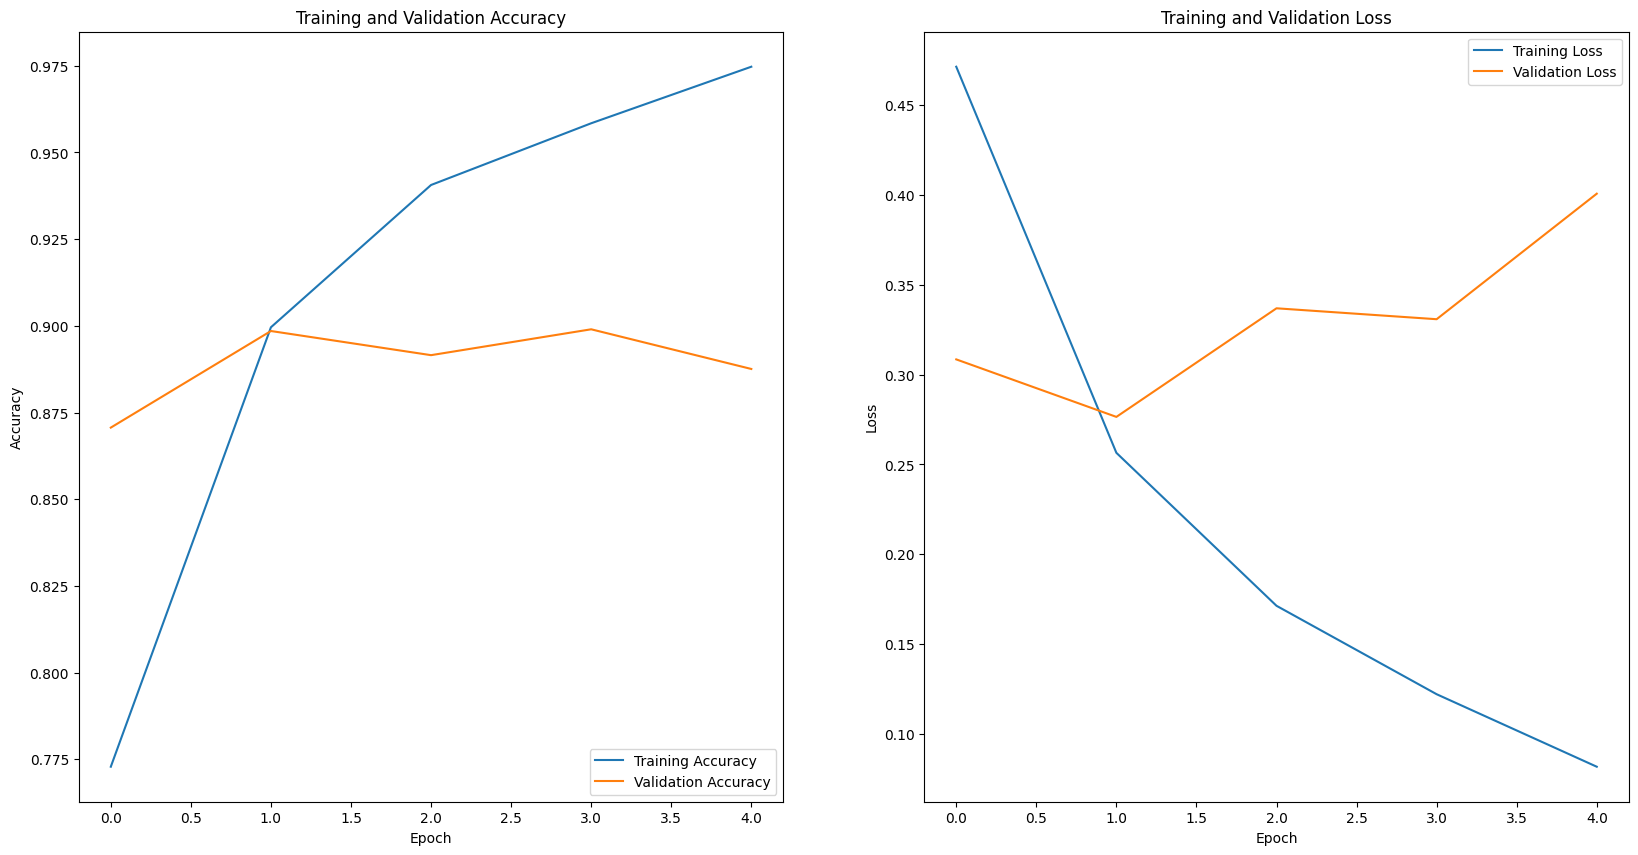

In [ ]:
# Plot accuracy and loss history

# Store accuracies
train_acc = tau_1_history.history['accuracy']
val_acc = tau_1_history.history['val_accuracy']

# Store losses
train_loss = tau_1_history.history['loss']
val_loss = tau_1_history.history['val_loss']


fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Plot accuracies
ax = axes[0]
ax.plot(train_acc, label='Training Accuracy')
ax.plot(val_acc, label='Validation Accuracy')
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.legend(loc='lower right')
ax.set_title('Training and Validation Accuracy')

# Plot losses
ax = axes[1]
ax.plot( train_loss, label='Training Loss')
ax.plot( val_loss, label='Validation Loss')
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend(loc='upper right')
ax.set_title('Training and Validation Loss')
plt.show()

In [ ]:
# Load best model weights
tau_1.load_weights('models_weights/tau_1_best_weights.h5')

In [ ]:
# Test tau_1
tau_1.evaluate(D1_test)

63/63 [==============================] - 35s 563ms/step - loss: 0.2502 - accuracy: 0.9110


[0.250240683555603, 0.9109895825386047]

###**Training $\tau_2$**

Let's train our first model.

We will start by importing the bert model:

In [ ]:
# Define tau_2
tau_2 = TFBertForSequenceClassification.from_pretrained(model_name, num_labels = 2)
# Show summary
tau_2.summary()

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
 dropout_75 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 108311810 (413.18 MB)
Trainable params: 108311810 (413.18 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Compile tau_2
tau_2.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = low_lr),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy'])

In [ ]:
# Train tau_2
tau_2_history = tau_2.fit(x = D2_train,
                          validation_data = D2_val,
                          epochs = number_of_epochs,
                          callbacks = get_model_checkpoint("tau_2"))

Epoch 1/5
375/375 [==============================] - 720s 2s/step - loss: 0.5625 - accuracy: 0.7259 - val_loss: 0.5131 - val_accuracy: 0.7643
Epoch 2/5
375/375 [==============================] - 682s 2s/step - loss: 0.5136 - accuracy: 0.7658 - val_loss: 0.4796 - val_accuracy: 0.7837
Epoch 3/5
375/375 [==============================] - 681s 2s/step - loss: 0.4397 - accuracy: 0.7977 - val_loss: 0.3987 - val_accuracy: 0.8219
Epoch 4/5
375/375 [==============================] - 676s 2s/step - loss: 0.3219 - accuracy: 0.8614 - val_loss: 0.4310 - val_accuracy: 0.8001
Epoch 5/5
375/375 [==============================] - 675s 2s/step - loss: 0.2300 - accuracy: 0.9109 - val_loss: 0.5093 - val_accuracy: 0.7927


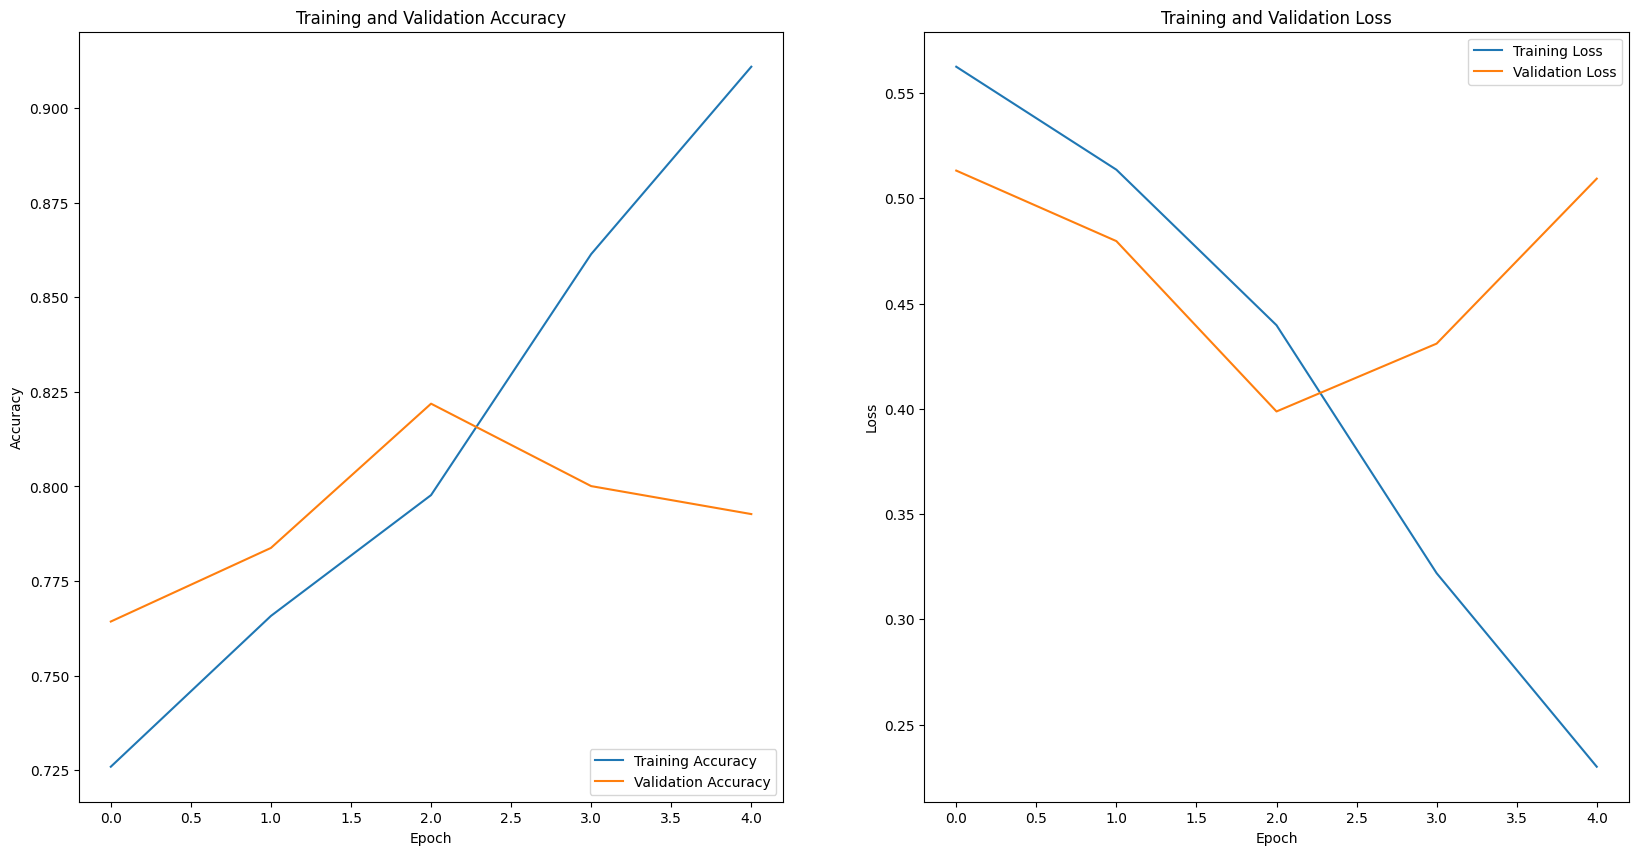

In [ ]:
# Plot accuracy and loss history

# Store accuracies
train_acc = tau_2_history.history['accuracy']
val_acc = tau_2_history.history['val_accuracy']

# Store losses
train_loss = tau_2_history.history['loss']
val_loss = tau_2_history.history['val_loss']


fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Plot accuracies
ax = axes[0]
ax.plot(train_acc, label='Training Accuracy')
ax.plot(val_acc, label='Validation Accuracy')
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.legend(loc='lower right')
ax.set_title('Training and Validation Accuracy')

# Plot losses
ax = axes[1]
ax.plot( train_loss, label='Training Loss')
ax.plot( val_loss, label='Validation Loss')
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend(loc='upper right')
ax.set_title('Training and Validation Loss')
plt.show()

In [ ]:
# Load best model weights
tau_2.load_weights('models_weights/tau_2_best_weights.h5')

In [ ]:
# Test tau_2
tau_2.evaluate(D2_test)

81/81 [==============================] - 45s 561ms/step - loss: 0.3848 - accuracy: 0.8296


[0.3848359286785126, 0.8296383023262024]

###**Check for tasks indipendence**

Since we've seen that in the original dataset each sentence could have more then one type of errors could happen that in the same sentence both spelling and other errors occur.

Given this consideration we want to check how much different are actually the $\tau_1$ and $\tau_2$ tasks.

It could happend that one task contain the other or vice versa.

In order to do so let's check the performance of each on the test of the other:

In [ ]:
# Evaluate tau_1 on tau_2 test set
tau_1.evaluate(D2_test)

81/81 [==============================] - 51s 519ms/step - loss: 0.9610 - accuracy: 0.6317


[0.9609919190406799, 0.6316608190536499]

In [ ]:
# Evaluate tau_2 on tau_1 test set
tau_2.evaluate(D1_test)

63/63 [==============================] - 34s 541ms/step - loss: 0.4632 - accuracy: 0.8021


[0.46323177218437195, 0.8020884990692139]

We can see out tasks are not really independent.

The task of detecting spelling errors only seems easier, since $\tau_2$ performs reasonably well also on $D_1$ test.

What we care here is that the accuracy of $\tau_1$ on $D_1$ test is not outperformed by $\tau_2$ and vice versa.

Since this is the case we can assume that in the $\tau_{mix}$ both models will
bring something to the table.

In order to measure how much each model influences the $\tau_{mix}$ results we can check how $\tau_1$ and $\tau_2$ indepentently performs on the final test, without being mixed:

In [ ]:
# Evaluate tau_1 on D_mix test set
tau_1.evaluate(D_mix_test)

85/85 [==============================] - 45s 531ms/step - loss: 0.6937 - accuracy: 0.7347


[0.6936527490615845, 0.7346938848495483]

In [ ]:
# Evaluate tau_2 on D_mix test set
tau_2.evaluate(D_mix_test)

85/85 [==============================] - 45s 533ms/step - loss: 0.4427 - accuracy: 0.7974


[0.44265076518058777, 0.7974026203155518]

###**Task vectors**

Let's start by getting the pre-trained **BERT** weights:

In [ ]:
# Initialize a pre-trained bert model
pre_trained_bert = TFBertForSequenceClassification.from_pretrained(model_name, num_labels = 2)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Access the weights of the encoding part of bert
pre_trained_bert_weights = pre_trained_bert.bert.get_weights()

Now we obtain $v_1$ and $v_2$ by computing the difference between the fine-tuned weights of $\tau_1$ and $tau_2$ and the initial bert model:

In [ ]:
# Get task vectors v_1 and v_2
v_1 = [tau_1.bert.get_weights()[i] - pre_trained_bert_weights[i] for i in range(len(pre_trained_bert_weights))]
v_2 = [tau_2.bert.get_weights()[i] - pre_trained_bert_weights[i] for i in range(len(pre_trained_bert_weights))]

Lastly we can get the final weights by summing the two tasks vector to the original weights of the model:

In [ ]:
# Get tau_mix bert weights
tau_mix_weights = [pre_trained_bert_weights[i] + v_1[i] + v_2[i] for i in range(len(pre_trained_bert_weights))]

Now we are ready to train the final $\tau_{mix}$.

Before doing that, in order to make a comparison, let's train the classifier from the frozen pre-trained bert (with original weights and not the ones obtained with task vectors).

Let's freeze the bert encoding layers:

In [ ]:
# Freeze the bert-encoder, in order to train just the classifier
pre_trained_bert.bert.trainable = False

In [ ]:
# Show pre_trained_bert summary
pre_trained_bert.summary()

Model: "tf_bert_for_sequence_classification_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
 dropout_113 (Dropout)       multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 108311810 (413.18 MB)
Trainable params: 1538 (6.01 KB)
Non-trainable params: 108310272 (413.17 MB)
_________________________________________________________________


In [ ]:
# Compile tau_mix
pre_trained_bert.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = high_lr),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy'])

In [ ]:
# # Train tau_mix
# pre_trained_bert_history = pre_trained_bert.fit(x = D_mix_train,
#                                                 validation_data = D_mix_val,
#                                                 epochs = number_of_epochs,
#                                                 callbacks = get_model_checkpoint("pre_trained_bert"))

Epoch 1/5
886/886 [==============================] - 594s 655ms/step - loss: 0.8142 - accuracy: 0.6025 - val_loss: 0.6953 - val_accuracy: 0.6253
Epoch 2/5
886/886 [==============================] - 584s 659ms/step - loss: 0.8065 - accuracy: 0.6156 - val_loss: 0.5579 - val_accuracy: 0.6782
Epoch 3/5
886/886 [==============================] - 576s 650ms/step - loss: 0.8296 - accuracy: 0.6163 - val_loss: 0.6498 - val_accuracy: 0.6253
Epoch 4/5
886/886 [==============================] - 576s 650ms/step - loss: 0.8186 - accuracy: 0.6180 - val_loss: 0.6786 - val_accuracy: 0.6303
Epoch 5/5
886/886 [==============================] - 576s 650ms/step - loss: 0.8219 - accuracy: 0.6167 - val_loss: 0.6166 - val_accuracy: 0.6253


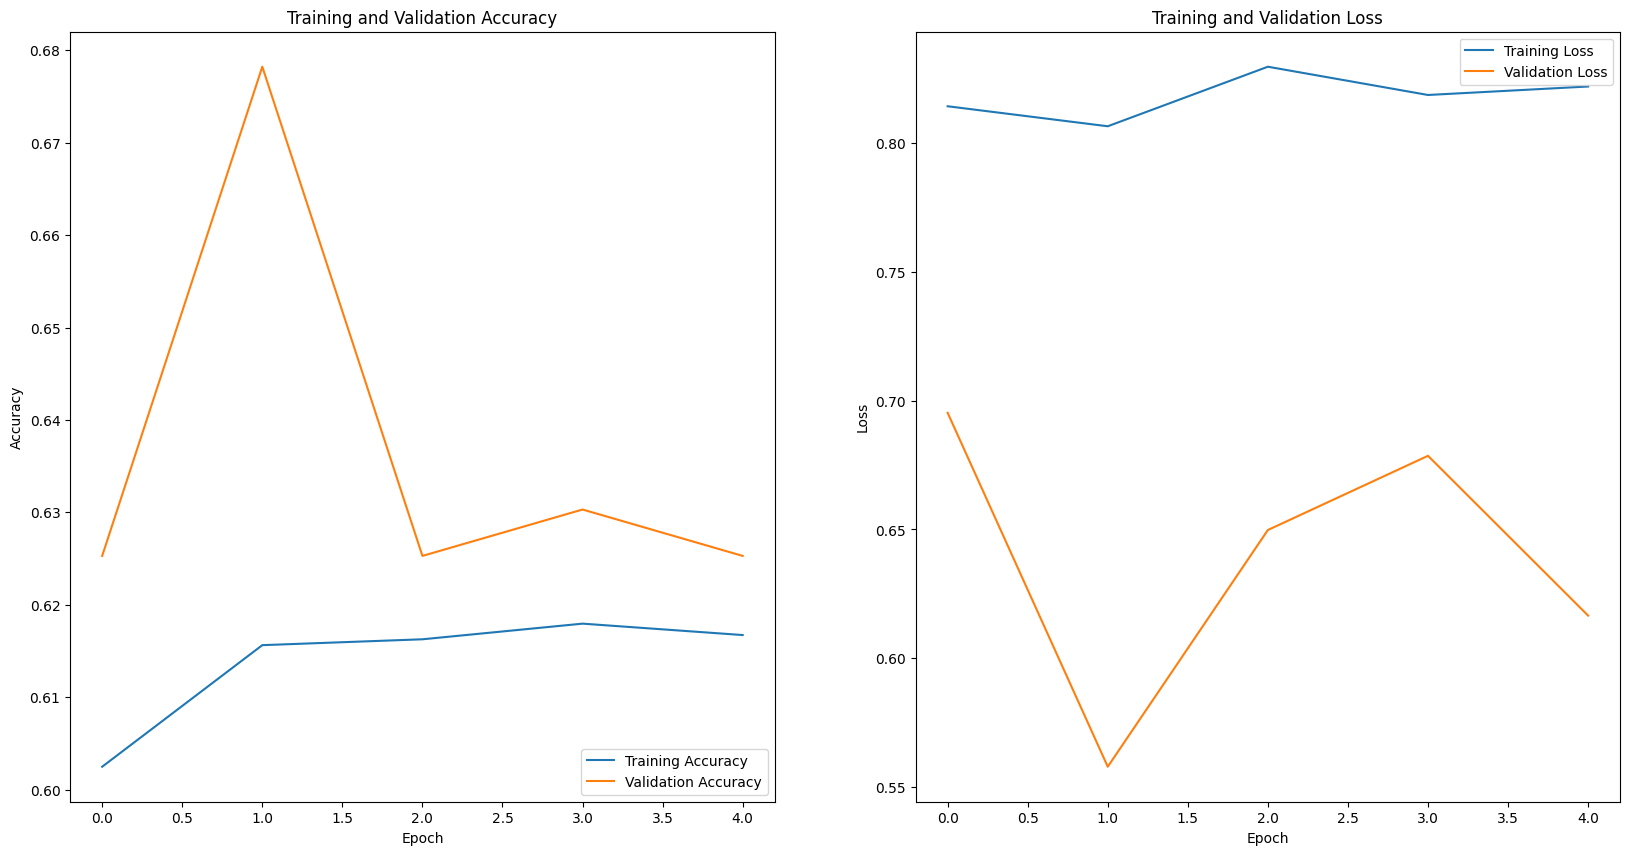

In [ ]:
# # Plot accuracy and loss history

# # Store accuracies
# train_acc = pre_trained_bert_history.history['accuracy']
# val_acc = pre_trained_bert_history.history['val_accuracy']

# # Store losses
# train_loss = pre_trained_bert_history.history['loss']
# val_loss = pre_trained_bert_history.history['val_loss']


# fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# # Plot accuracies
# ax = axes[0]
# ax.plot(train_acc, label='Training Accuracy')
# ax.plot(val_acc, label='Validation Accuracy')
# ax.set_xlabel("Epoch")
# ax.set_ylabel("Accuracy")
# ax.legend(loc='lower right')
# ax.set_title('Training and Validation Accuracy')

# # Plot losses
# ax = axes[1]
# ax.plot( train_loss, label='Training Loss')
# ax.plot( val_loss, label='Validation Loss')
# ax.set_xlabel("Epoch")
# ax.set_ylabel("Loss")
# ax.legend(loc='upper right')
# ax.set_title('Training and Validation Loss')
# plt.show()

In [ ]:
# Load best model weights
pre_trained_bert.load_weights('models_weights/pre_trained_bert_best_weights.h5')

In [ ]:
# Test tau_mix
pre_trained_bert.evaluate(D_mix_test)

85/85 [==============================] - 48s 560ms/step - loss: 0.5659 - accuracy: 0.6905


[0.5659472942352295, 0.6905380487442017]

###**Training $\tau_{mix}$**

In [ ]:
# Initialize the tau_mix model
tau_mix = TFBertForSequenceClassification.from_pretrained(model_name, num_labels = 2)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Set weights for the bert encoder
tau_mix.bert.set_weights(tau_mix_weights)

In [ ]:
# Freeze the bert-encoder, in order to train just the classifier
tau_mix.bert.trainable = False

In [ ]:
# Show tau_mix summary
tau_mix.summary()

Model: "tf_bert_for_sequence_classification_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
 dropout_151 (Dropout)       multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 108311810 (413.18 MB)
Trainable params: 1538 (6.01 KB)
Non-trainable params: 108310272 (413.17 MB)
_________________________________________________________________


In [ ]:
# Compile tau_mix
tau_mix.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = high_lr),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy'])

In [ ]:
# Train tau_mix
tau_mix_history = tau_mix.fit(x = D_mix_train,
                              validation_data = D_mix_val,
                              epochs = number_of_epochs,
                              callbacks = get_model_checkpoint("tau_mix"))

Epoch 1/5
886/886 [==============================] - 596s 658ms/step - loss: 0.4988 - accuracy: 0.8167 - val_loss: 0.3846 - val_accuracy: 0.8152
Epoch 2/5
886/886 [==============================] - 589s 665ms/step - loss: 0.5253 - accuracy: 0.8113 - val_loss: 0.3693 - val_accuracy: 0.8393
Epoch 3/5
886/886 [==============================] - 577s 651ms/step - loss: 0.5037 - accuracy: 0.8110 - val_loss: 0.5556 - val_accuracy: 0.7608
Epoch 4/5
886/886 [==============================] - 591s 667ms/step - loss: 0.5245 - accuracy: 0.8099 - val_loss: 0.3577 - val_accuracy: 0.8535
Epoch 5/5
886/886 [==============================] - 577s 651ms/step - loss: 0.5043 - accuracy: 0.8123 - val_loss: 0.4241 - val_accuracy: 0.8266


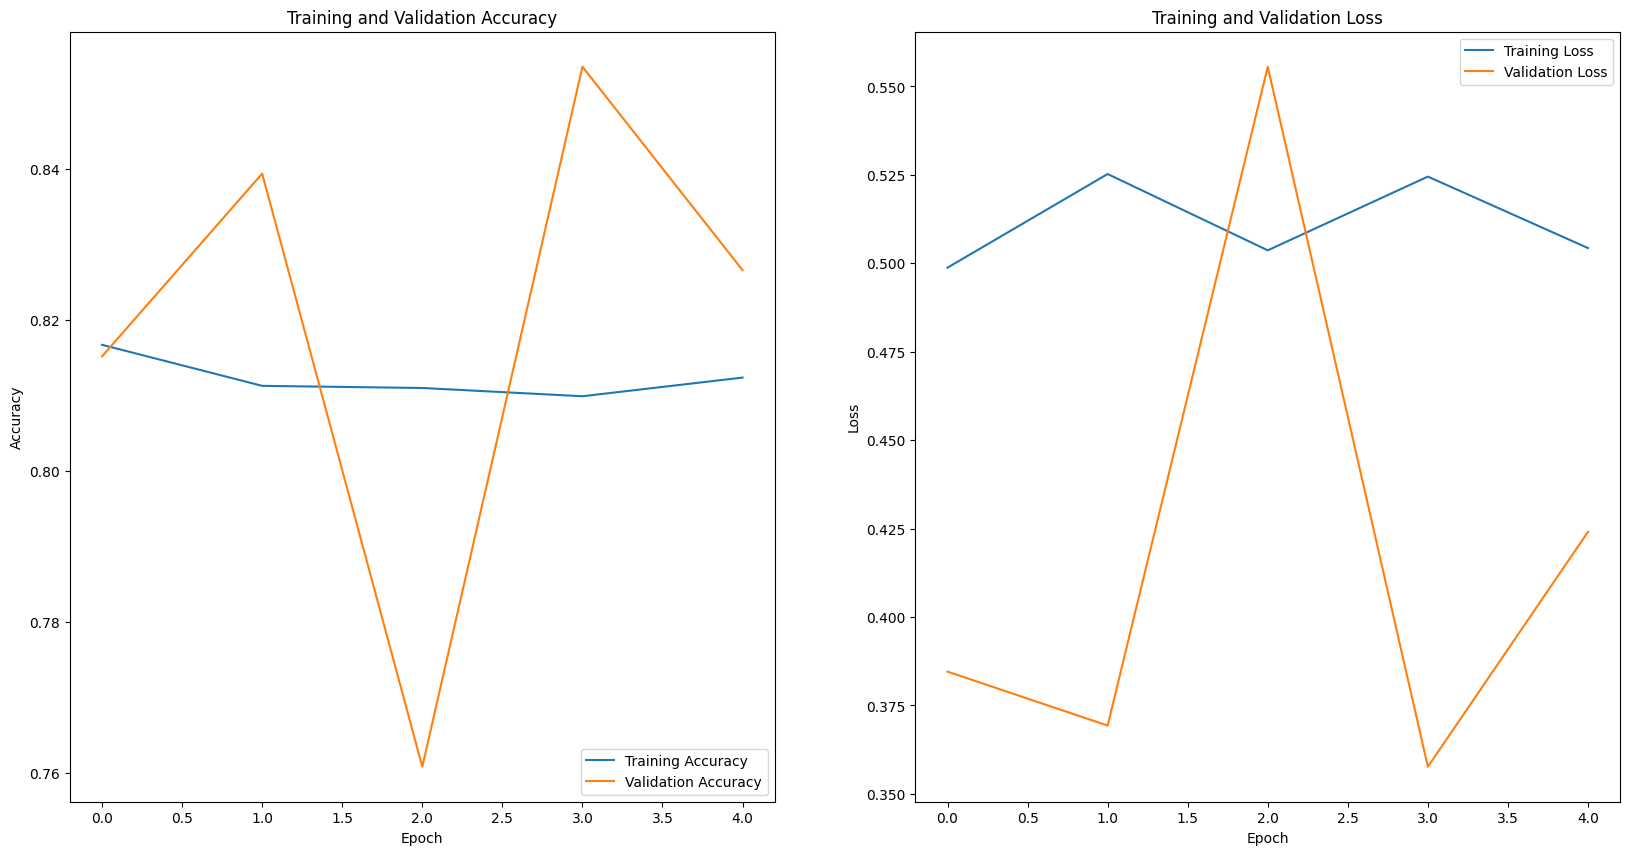

In [ ]:
# Plot accuracy and loss history

# Store accuracies
train_acc = tau_mix_history.history['accuracy']
val_acc = tau_mix_history.history['val_accuracy']

# Store losses
train_loss = tau_mix_history.history['loss']
val_loss = tau_mix_history.history['val_loss']


fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Plot accuracies
ax = axes[0]
ax.plot(train_acc, label='Training Accuracy')
ax.plot(val_acc, label='Validation Accuracy')
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.legend(loc='lower right')
ax.set_title('Training and Validation Accuracy')

# Plot losses
ax = axes[1]
ax.plot( train_loss, label='Training Loss')
ax.plot( val_loss, label='Validation Loss')
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend(loc='upper right')
ax.set_title('Training and Validation Loss')
plt.show()

In [ ]:
# Load best model weights
tau_mix.load_weights('models_weights/tau_mix_best_weights.h5')

In [ ]:
# Test tau_mix
tau_mix.evaluate(D_mix_test)

85/85 [==============================] - 48s 560ms/step - loss: 0.4369 - accuracy: 0.8115


[0.43694716691970825, 0.8115027546882629]

### **Conclusions**

Let's summarize our results in a final table showing all accuracies we've obtained:



|              | $D_1$     | $D_2$     |$D_{mix}$ |
|--------------|-----------|-----------|----------|
| $\tau_1$     |  $0.9110$ | $0.6317$  | $0.7347$ |
| $\tau_2$     |  $0.8021$ | $0.8296$  | $0.7974$ |
| $\tau_{mix}$ |    -      |   -       | $0.8115$ |
| $baseline$   |    -      |   -       | $0.6905$ |




The model initialized with the weights of the tasks vectors achieves a $+12\%$ accuracy with respect to the baseline.


The results of $\tau_{mix}$ are mainly due to $\tau_2$, but adding also the task vector $v_1$ gives a $+2\%$ accuracy.

Obviously the training shown in this notebook is **not efficient**.

But if we assume that we already had the two models $\tau_1$ and $\tau_2$, computing the tasks vectors and the training of just $1500$ parameters to generalize their task is a joke with respect to the $108310272$ parameters tuning needed for BERT.

In conclusion, when the tasks vectors are already available, this technique is incredibily easy to implement and efficient.